## 0. 모듈 및 csv 가져오기

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix,accuracy_score
import lightgbm as lgbm
import numpy as np 

plt.style.use('ggplot')

In [2]:
train=pd.read_csv('train.csv',index_col=0)
test=pd.read_csv('test_x.csv',index_col=0)
submission=pd.read_csv('sample_submission.csv',index_col=0)

In [3]:
train.shape

(45532, 77)

In [4]:
train.head()

,QaA,QaE,QbA,QbE,QcA,QcE,QdA,QdE,QeA,QeE,...,wr_04,wr_05,wr_06,wr_07,wr_08,wr_09,wr_10,wr_11,wr_12,wr_13
index,,,,,,,,,,,,,,,,,,,,,
0,3.0,363,4.0,1370,5.0,997,1.0,1024,2.0,1577,...,0,1,0,1,1,0,1,0,1,1
1,5.0,647,5.0,1313,3.0,3387,5.0,2969,1.0,4320,...,1,1,0,1,1,0,1,0,1,1
2,4.0,1623,1.0,1480,1.0,1021,4.0,3374,5.0,1333,...,1,1,0,1,1,1,1,0,1,1
3,3.0,504,3.0,2311,4.0,992,3.0,3245,1.0,357,...,0,0,0,0,1,0,1,0,1,1
4,1.0,927,1.0,707,5.0,556,2.0,1062,1.0,1014,...,1,1,1,1,1,0,1,1,1,1


## 1. feature들의 관계 분석하기

### 1.1) Pearson 상관 계수 분석

In [5]:
cols=list(train.columns)
correlation=train[cols[40:49]+cols[59:61]]
correlation.corr(method='pearson')

,education,engnat,familysize,hand,married,urban,voted
education,1.000000,0.136295,-0.002711,-0.032205,0.242552,-0.010105,-0.319899
engnat,0.136295,1.000000,-0.002836,-0.032591,-0.113444,0.138094,0.029470
familysize,-0.002711,-0.002836,1.000000,-0.001706,-0.002835,-0.007254,0.004266
hand,-0.032205,-0.032591,-0.001706,1.000000,-0.011346,-0.009413,0.009930
married,0.242552,-0.113444,-0.002835,-0.011346,1.000000,-0.064786,-0.214489
urban,-0.010105,0.138094,-0.007254,-0.009413,-0.064786,1.000000,0.064410
voted,-0.319899,0.029470,0.004266,0.009930,-0.214489,0.064410,1.000000


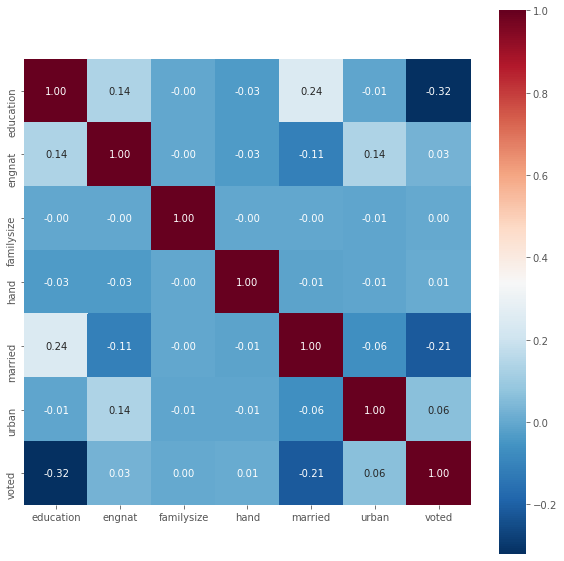

In [6]:
plt.figure(figsize=(10,10))
sns.heatmap(correlation.corr(), cmap='RdBu_r', square=True, cbar=True, annot=True, fmt=".2f")
plt.show()

voted와 가장 높은 상관관계를 갖는 feature로는 education , married 가 있다 .

## 2. 타겟 변수 확인

2    24898
1    20634
Name: voted, dtype: int64

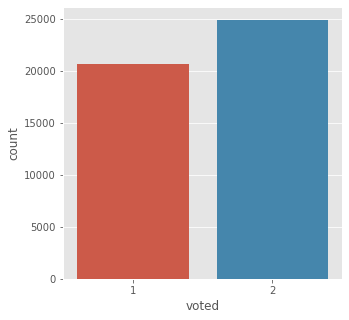

In [7]:
plt.rcParams["figure.figsize"] = (5,5)
sns.countplot(train['voted'])
train['voted'].value_counts()

목적 변수의 데이터 값이 고루 분포되어 있으므로 목적 변수에 대해서는 따로 처리르 해줄 필요가 없다.

## 3. 결측치 처리
여기서는 결측치는 없지만 설문 조사 파트에서 무응답이 있으므로 어떻게 처리해야 할지 생각해보자

In [8]:
train.isnull().sum()

QaA      0
QaE      0
QbA      0
QbE      0
QcA      0
        ..
wr_09    0
wr_10    0
wr_11    0
wr_12    0
wr_13    0
Length: 77, dtype: int64

In [9]:
test.isnull().sum()

QaA      0
QaE      0
QbA      0
QbE      0
QcA      0
        ..
wr_09    0
wr_10    0
wr_11    0
wr_12    0
wr_13    0
Length: 76, dtype: int64

## 4. EDA(exploratory data analysis)
먼저 미응답이 있을 수 없는 값들을 처리하고 , 그 다음 미응답값을 처리한다.

### 4.1) gender

<AxesSubplot:xlabel='gender', ylabel='count'>

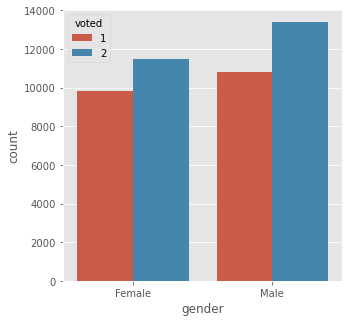

In [10]:
sns.countplot(data=train, x='gender', hue='voted')

성별 female,male 모두 voted 하지 않은 사람의 비율이 높으므로 관련이 없다.

In [11]:
train.drop(columns='gender',inplace=True)
test.drop(columns='gender',inplace=True)

### 4.2) age_group

<AxesSubplot:xlabel='age_group', ylabel='count'>

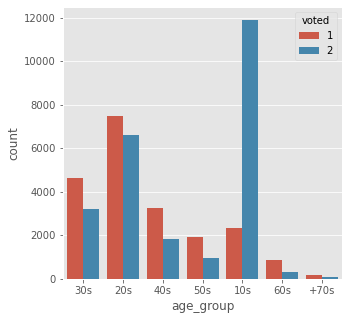

In [12]:
sns.countplot(data=train, x='age_group', hue='voted')

10대만 투표를 하지 않을 가능성이 매우 높고 , 나머지는 그렇지 않으므로 10대인 경우를 1 나머지를 전부 0로 인코딩해준다.

In [13]:
train.loc[train['age_group']=='10s','teen']=1
train.loc[train['age_group']!='10s','teen']=0
test.loc[test['age_group']=='10s','teen']=1
test.loc[test['age_group']!='10s','teen']=0

print(train['teen'].unique())
print(test['teen'].unique())

[0. 1.]
[1. 0.]


<AxesSubplot:xlabel='teen', ylabel='count'>

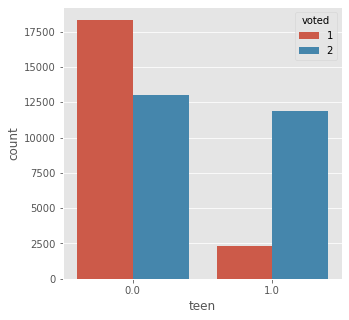

In [14]:
train.drop(columns='age_group',inplace=True)
test.drop(columns='age_group',inplace=True)
sns.countplot(data=train, x='teen', hue='voted')

### 4.3) familysize : 이상치 존재

<AxesSubplot:xlabel='familysize', ylabel='count'>

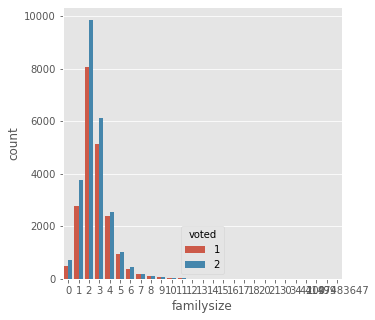

In [15]:
sns.countplot(data=train, x='familysize', hue='voted')

음 그래프가 아주 고약해

In [16]:
train['familysize'].unique()

array([         4,          3,          0,          2,          6,
                1,          5,          8,          7,          9,
              999,         11,         10,         15,         14,
               12,         21,         13,         20,         44,
               16, 2147483647,         17,        100,         34,
               30,         18], dtype=int64)

<AxesSubplot:xlabel='familysize', ylabel='count'>

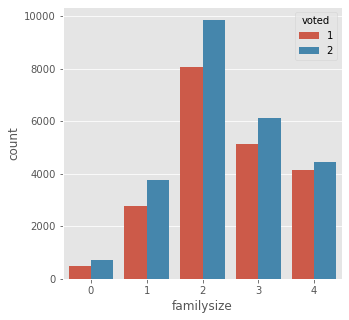

In [17]:
train.loc[train['familysize']>4,'familysize']=4
test.loc[train['familysize']>4,'familysize']=4
sns.countplot(data=train, x='familysize', hue='voted')

바꿨음에도 큰 경향성을 보이지 않아서 drop해준다.

In [18]:
train.drop(columns='familysize',inplace=True)
test.drop(columns='familysize',inplace=True)

### 4.4) education : 결측치 존재

<AxesSubplot:xlabel='education', ylabel='count'>

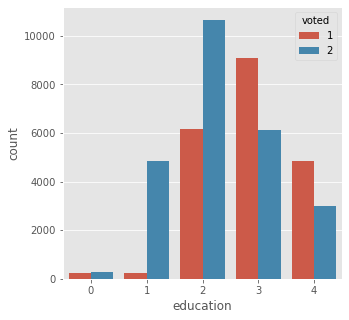

In [19]:
sns.countplot(data=train, x='education', hue='voted')

education의 미응답 0을 제외하면 , 교육을 덜 받은 축에 속하는 1,2 집단이 그렇지 않은 3,4 집단에 비해 voted하지 않는 경향을 보인다. 

이 자료는 매우 중요해 보이므로 미응답 0을 채워본다.

교육과 가장 밀접한 연관이 있는 feature는 무엇일까 ? 어린 사람일수록 고등교육 이하의 교육을 받았을 확률이 높다는 가정 하에 age와 연관지어보자.

In [20]:
graph=pd.read_csv('train.csv',index_col=0)

<AxesSubplot:xlabel='age_group'>

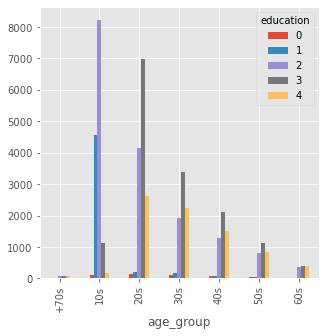

In [21]:
age_edu=graph.groupby('education').age_group.value_counts()
plt.rcParams["figure.figsize"] = (5,5)
age_edu.unstack(level=0).plot(kind='bar', subplots=False)

이때 age_group 10s를 위에서 1로 설정했는데 10s만 2이하의 교육을 받은 사람의 비율이 높으므로 teen==1인 집단 사람들의 education 수준을 2로, 나머지를 3으로 설정한다.

In [22]:
train.loc[(train['education']==0 )& (train['teen']==1),'education']=2
train.loc[(train['education']==0 )& (train['teen']==0),'education']=3

test.loc[(test['education']==0 )& (test['teen']==1),'education']=2
test.loc[(test['education']==0 )& (test['teen']==0),'education']=3

<AxesSubplot:xlabel='education', ylabel='count'>

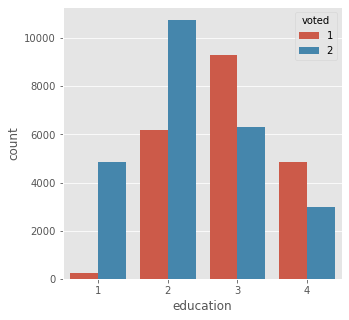

In [23]:
sns.countplot(data=train, x='education', hue='voted')

이때 education 받은 그룹을 3,4 그렇지 않은 그룹을 1,2로 설정하고 각각 1,0으로 둔다.

<AxesSubplot:xlabel='education', ylabel='count'>

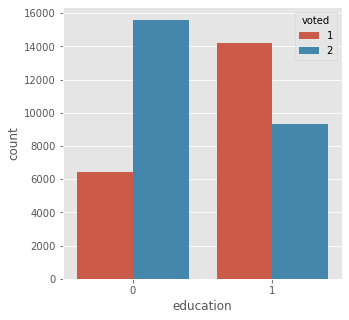

In [24]:
train.loc[(train['education']==1) | (train['education']==2),'education']=0
train.loc[(train['education']==3) | (train['education']==4),'education']=1

test.loc[(test['education']==1 ) | (test['education']==2),'education']=0
test.loc[(test['education']==3 ) | (test['education']==4),'education']=1

sns.countplot(data=train, x='education', hue='voted')

### 4.5) engnat

<AxesSubplot:xlabel='engnat', ylabel='count'>

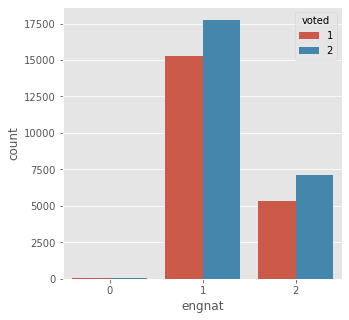

In [25]:
sns.countplot(data=train, x='engnat', hue='voted')

연관성이 없어보이고 결측치도 있으므로 drop한다.

In [26]:
train.drop(columns='engnat',inplace=True)
test.drop(columns='engnat',inplace=True)

### 4.6) hand

<AxesSubplot:xlabel='hand', ylabel='count'>

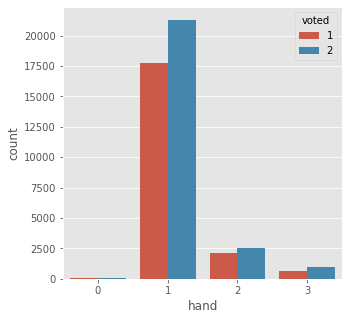

In [27]:
sns.countplot(data=train, x='hand', hue='voted')

이것도 매한가지로 연관이 전혀 없으므로 drop 

In [28]:
train.drop(columns='hand',inplace=True)
test.drop(columns='hand',inplace=True)

### 4.6) married : 결측치 존재

<AxesSubplot:xlabel='married', ylabel='count'>

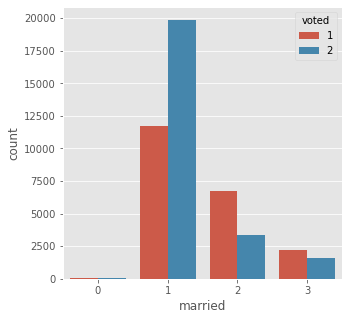

In [29]:
sns.countplot(data=train, x='married', hue='voted')

1번으로 응답한 집단만 크게 2에 치우치는 경향이 있다. 즉, 1= never married인 분들과 결혼을 한번이라도 했던 집단으로 나누는 것이 좋아보인다. 그러기 전에 결측치를 채워보기 위해 married도 결국 나이와 가장 큰 관련이 있을 거라는 가설을 세운다. 나이가 차면 대부분 결혼을 하니깐 ..!

<AxesSubplot:xlabel='age_group'>

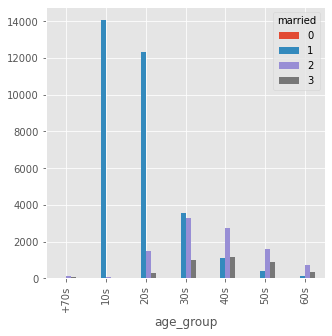

In [30]:
married_age=graph.groupby('married').age_group.value_counts()
married_age
married_age.unstack(level=0).plot(kind='bar', subplots=False)

실제로, 10s,20s는 거의 대부분 결혼을 하지 않았다. 30s는 currently married + previously married를 합치면 never married를 초과할 것 같기 때문에 제외한다. 이미 age를 가공해버렸기 때문에 새로 불러오자.

In [31]:
train.drop(columns='married',inplace=True)
test.drop(columns='married',inplace=True)

In [32]:
ma_train=pd.read_csv('train.csv',index_col=0)
ma_test=pd.read_csv('test_x.csv',index_col=0)

ma_train.loc[(ma_train['married']==0) & (ma_train['age_group']=='10s'),'married']=1
ma_train.loc[(ma_train['married']==0) & (ma_train['age_group']=='20s'),'married']=1
ma_train.loc[ma_train['married']==0,'married']=3


ma_test.loc[(ma_test['married']==0) & (ma_test['age_group']=='10s'),'married']=1
ma_test.loc[(ma_test['married']==0) & (ma_test['age_group']=='20s'),'married']=1
ma_test.loc[ma_test['married']==0,'married']=3

print(ma_train['married'].unique())
print(ma_test['married'].unique())

[3 1 2]
[1 2 3]


<AxesSubplot:xlabel='age_group'>

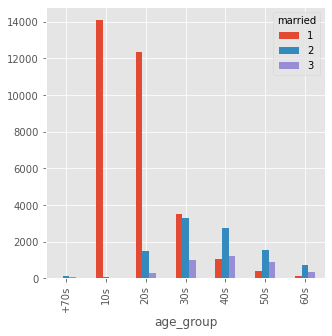

In [33]:
married_age=ma_train.groupby('married').age_group.value_counts()
married_age
married_age.unstack(level=0).plot(kind='bar', subplots=False)

<AxesSubplot:xlabel='married', ylabel='count'>

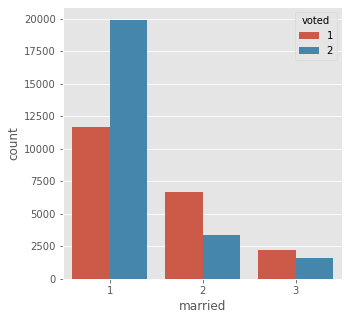

In [34]:
train['married']=ma_train['married']
test['married']=ma_test['married']
sns.countplot(data=train, x='married', hue='voted')

<AxesSubplot:xlabel='married', ylabel='count'>

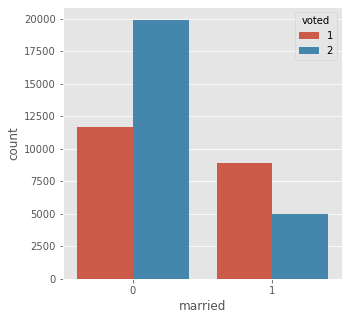

In [35]:
train.loc[train['married']==1,'married']=0
train.loc[(train['married']==2) | (train['married']==3),'married']=1

test.loc[test['married']==1  ,'married']=0
test.loc[(test['married']==2 ) | (test['married']==3),'married']=1

sns.countplot(data=train, x='married', hue='voted')

### 4.7) urban : 결측치 존재 

<AxesSubplot:xlabel='urban', ylabel='count'>

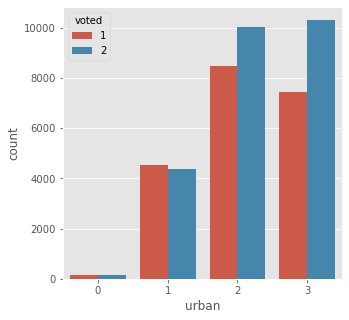

In [36]:
sns.countplot(data=train, x='urban', hue='voted')

아예 관련이 없지는 않고 rural에서는 투표를 하는 사람의 비율이 높고 suburban과 urban에서는 투표를 안하는 사람의 비율이 높다. 즉,  1==rural인 경우와 아닌 경우로 나누는 것이 괜찮아 보인다. 또 결측치가 있으니까 수치화해보자.

In [37]:
urban_voted = train[['urban', 'voted']].groupby(['urban'], as_index=True).mean()
urban_voted

,voted
urban,
0,1.490683
1,1.492872
2,1.541545
3,1.580402


생각했던 것보다 큰 경향성을 가진다. 원핫 인코딩을 사용해서 각자 지역마다 따로 나눠주는 방식을 선택하는 것이 좋겠다.그 전에 결측치 처리하자. engnat과 가장 높은 상관계수 가지므로 engnat 사용해 볼 것.

In [38]:
train.drop(columns='urban',inplace=True)
test.drop(columns='urban',inplace=True)

In [39]:
ur_train=pd.read_csv('train.csv',index_col=0)
ur_test=pd.read_csv('test_x.csv',index_col=0)

In [40]:
urban_eng=ur_train.groupby('urban').engnat.value_counts()
urban_eng

urban  engnat
0      1           230
       2            89
       0             3
1      1          6681
       2          2217
       0            11
2      1         15161
       2          3339
       0            34
3      1         10952
       2          6786
       0            29
Name: engnat, dtype: int64

<AxesSubplot:xlabel='engnat'>

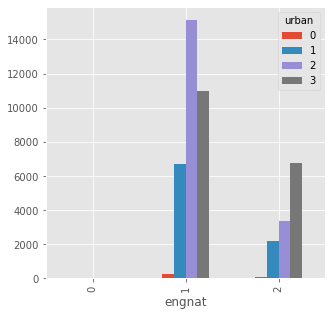

In [41]:
urban_eng.unstack(level=0).plot(kind='bar', subplots=False)

engnat==1일때 urban==2 / engnat == 0,2일때 urban ==3

In [42]:
ur_train.loc[(ur_train['urban']==0) & (ur_train['engnat']==1),'urban']=2
ur_train.loc[(ur_train['urban']==0) & (ur_train['engnat']==2),'urban']=3
ur_train.loc[(ur_train['urban']==0) & (ur_train['engnat']==0),'urban']=3

ur_test.loc[(ur_test['urban']==0) & (ur_test['engnat']==1),'urban']=2
ur_test.loc[(ur_test['urban']==0) & (ur_test['engnat']==2),'urban']=3
ur_test.loc[(ur_test['urban']==0) & (ur_test['engnat']==0),'urban']=3

print(ur_train['urban'].unique())
print(ur_train['urban'].unique())

[1 3 2]
[1 3 2]


In [43]:
train['rural']=(ur_train['urban']==1)
train['suburban']=(ur_train['urban']==2)
train['urban']=(ur_train['urban']==3)

test['rural']=(ur_test['urban']==1)
test['suburban']=(ur_test['urban']==2)
test['urban']=(ur_test['urban']==3)

train['urban']

index
0        False
1         True
2        False
3         True
4        False
         ...  
45527     True
45528    False
45529    False
45530    False
45531    False
Name: urban, Length: 45532, dtype: bool

### 4.8) race

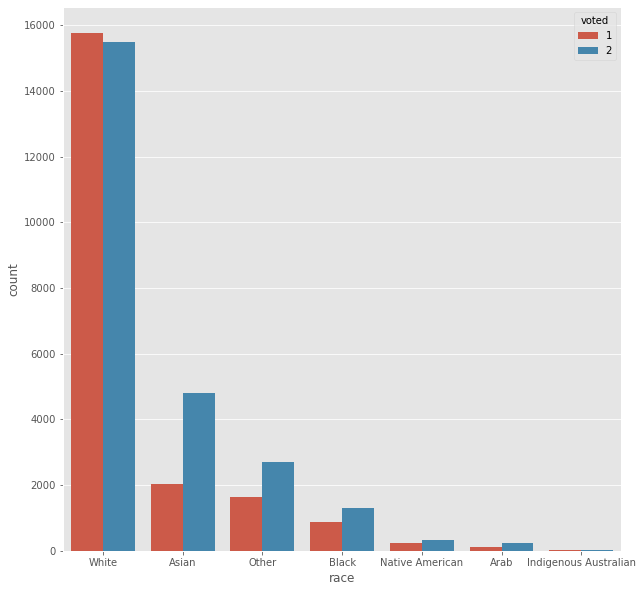

In [44]:
plt.rcParams["figure.figsize"] = (10,10)
sns.countplot(data=train, x='race', hue='voted')
plt.rcParams["figure.figsize"] = (5,5)

white를 제외한 나머지 인종은 전부 투표를 안하는 사람이 더 많다. 
지표로 쓰이기 적절하다.

In [45]:
train['white']=(train['race']=='White')
test['white']=(test['race']=='White')

train.drop(columns='race',inplace=True)
test.drop(columns='race',inplace=True)

In [46]:
train['white']

index
0         True
1        False
2         True
3        False
4         True
         ...  
45527     True
45528     True
45529     True
45530     True
45531     True
Name: white, Length: 45532, dtype: bool

In [47]:
test['white']

index
0         True
1        False
2        False
3         True
4         True
         ...  
11378    False
11379    False
11380     True
11381     True
11382    False
Name: white, Length: 11383, dtype: bool

### 4.9) religion

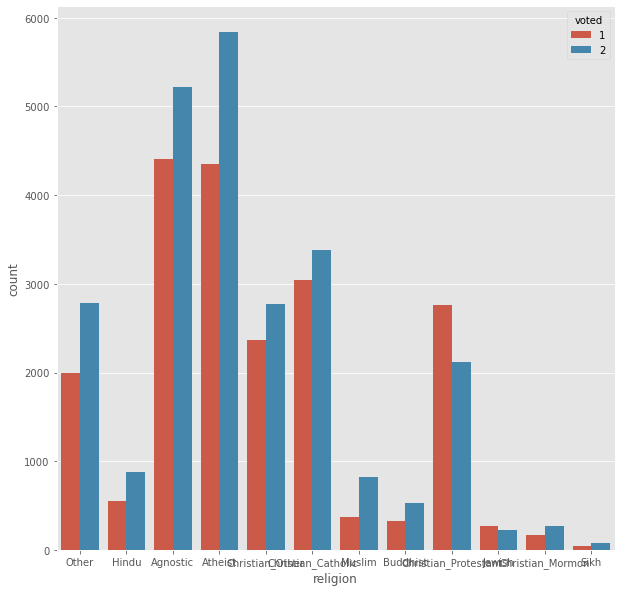

In [48]:
plt.rcParams["figure.figsize"] = (10,10)
sns.countplot(data=train, x='religion', hue='voted')
plt.rcParams["figure.figsize"] = (5,5)

으으음 뚜렷한 차이를 발견하기가 매우 어려워서 그냥 drop할래여

In [49]:
train.drop(columns='religion',inplace=True)
test.drop(columns='religion',inplace=True)

근데 생각보다 지역적인 부분이 그닥 도움이 되는 것 같진 않아서 drop 한다.

In [50]:
train.drop(columns='rural',inplace=True)
test.drop(columns='rural',inplace=True)
train.drop(columns='suburban',inplace=True)
test.drop(columns='suburban',inplace=True)
train.drop(columns='urban',inplace=True)
test.drop(columns='urban',inplace=True)

## 5. 주관적인 답변 
솔직히 아직 뭔 연관이 있는지 눈치도 못챔

### 5.1) wf/wr 
wf= 실존하지 않는 단어에 대해 뜻을 알고 있다고 답변

wr=실존하는 단어에 대해 뜻을 알고 있다고 답변

실존하는 단어의 정의를 많이 아는 것과 실존하지 않는 단어의 정의를 많이 아는 것은 정말 큰 차이가 있다고 생각한다. 내 가정으로는 ,

실존하는 단어를 많이 아는 것 = 똑똑이

실존하지 않는 단어를 많이 아는 것 = 구라쟁이

In [51]:
cols=list(train.columns)
w=train[cols[51:68]]
w

,voted,wf_01,wf_02,wf_03,wr_01,wr_02,wr_03,wr_04,wr_05,wr_06,wr_07,wr_08,wr_09,wr_10,wr_11,wr_12,wr_13
index,,,,,,,,,,,,,,,,,
0,2,0,0,0,0,1,0,0,1,0,1,1,0,1,0,1,1
1,2,0,0,0,0,1,0,1,1,0,1,1,0,1,0,1,1
2,1,0,0,1,1,1,0,1,1,0,1,1,1,1,0,1,1
3,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,1
4,1,0,1,0,1,1,0,1,1,1,1,1,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45527,2,0,0,1,1,1,0,1,1,0,1,1,1,1,0,1,1
45528,2,0,0,1,1,1,1,1,1,0,1,1,1,1,0,1,1
45529,1,0,0,0,1,1,0,1,1,0,1,1,0,1,0,1,1


아니 아무리봐도 솔직히 그 연관성을 잘 모르겠다
누가 이딴 문제 내래;;

<AxesSubplot:xlabel='wf_sum', ylabel='count'>

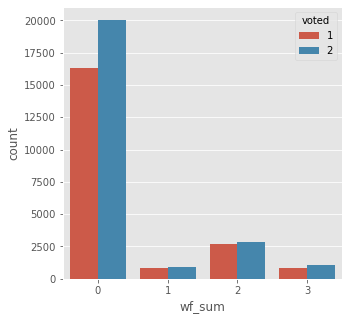

In [52]:
w['wf_sum']=w['wf_01']+w['wf_02']+w['wf_02']
sns.countplot(data=w, x='wf_sum', hue='voted')

<AxesSubplot:xlabel='honest', ylabel='count'>

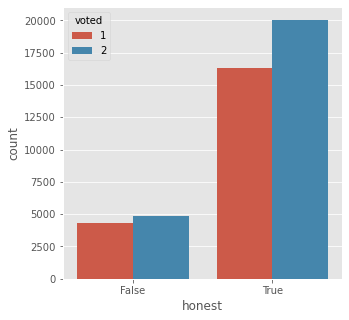

In [53]:
w['honest']=(w['wf_sum']==0)
sns.countplot(data=w, x='honest', hue='voted')

으음 .. 연관이 전혀 없어

<AxesSubplot:xlabel='wr_sum', ylabel='count'>

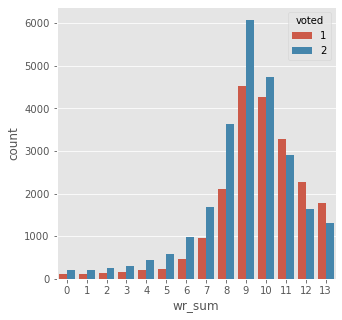

In [54]:
w['wr_sum']=w['wr_01']+w['wr_02']+w['wr_03']+w['wr_04']+w['wr_05']+w['wr_06']+w['wr_07']+w['wr_08']+w['wr_09']+w['wr_10']+w['wr_11']+w['wr_12']+w['wr_13']
sns.countplot(data=w, x='wr_sum', hue='voted')

<AxesSubplot:xlabel='wise', ylabel='count'>

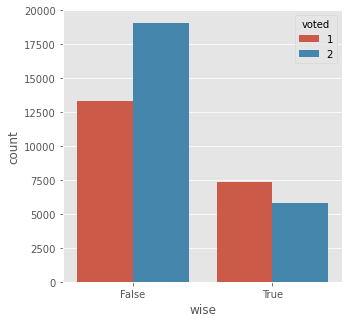

In [55]:
w['wise']=(w['wr_sum']>10)
sns.countplot(data=w, x='wise', hue='voted')

오 역시 똑똑이들이 투표 더 많이 했다

In [56]:
train['wr_sum']=train['wr_01']+train['wr_02']+train['wr_03']+train['wr_04']+train['wr_05']+train['wr_06']+train['wr_07']+train['wr_08']+train['wr_09']+train['wr_10']+train['wr_11']+train['wr_12']+train['wr_13']
test['wr_sum']=test['wr_01']+test['wr_02']+test['wr_03']+test['wr_04']+test['wr_05']+test['wr_06']+test['wr_07']+test['wr_08']+test['wr_09']+test['wr_10']+test['wr_11']+test['wr_12']+test['wr_13']
train['wr_sum']

index
0         7
1         8
2        10
3         5
4        11
         ..
45527    10
45528    11
45529     9
45530    10
45531     9
Name: wr_sum, Length: 45532, dtype: int64

<AxesSubplot:xlabel='wise', ylabel='count'>

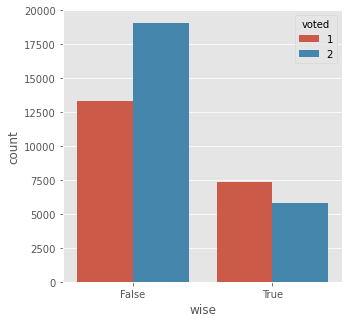

In [57]:
train['wise']=(train['wr_sum']>10)
test['wise']=(test['wr_sum']>10)
sns.countplot(data=train, x='wise', hue='voted')

In [58]:
train.drop(columns='wr_01',inplace=True)
train.drop(columns='wr_02',inplace=True)
train.drop(columns='wr_03',inplace=True)
train.drop(columns='wr_04',inplace=True)
train.drop(columns='wr_05',inplace=True)
train.drop(columns='wr_06',inplace=True)
train.drop(columns='wr_07',inplace=True)
train.drop(columns='wr_08',inplace=True)
train.drop(columns='wr_09',inplace=True)
train.drop(columns='wr_10',inplace=True)
train.drop(columns='wr_11',inplace=True)
train.drop(columns='wr_12',inplace=True)
train.drop(columns='wr_13',inplace=True)
train.drop(columns='wf_01',inplace=True)
train.drop(columns='wf_02',inplace=True)
train.drop(columns='wf_03',inplace=True)
train.drop(columns='wr_sum',inplace=True)

test.drop(columns='wr_01',inplace=True)
test.drop(columns='wr_02',inplace=True)
test.drop(columns='wr_03',inplace=True)
test.drop(columns='wr_04',inplace=True)
test.drop(columns='wr_05',inplace=True)
test.drop(columns='wr_06',inplace=True)
test.drop(columns='wr_07',inplace=True)
test.drop(columns='wr_08',inplace=True)
test.drop(columns='wr_09',inplace=True)
test.drop(columns='wr_10',inplace=True)
test.drop(columns='wr_11',inplace=True)
test.drop(columns='wr_12',inplace=True)
test.drop(columns='wr_13',inplace=True)
test.drop(columns='wf_01',inplace=True)
test.drop(columns='wf_02',inplace=True)
test.drop(columns='wf_03',inplace=True)
test.drop(columns='wr_sum',inplace=True)

뭔가 나쁘지 않은 것 같음 한번 더 모델 돌려보자

In [59]:
cols=list(test.columns)
test_ver=test[[cols[40]]+cols[51:56]]
test_ver

,education,teen,married,white,wise
index,,,,,
0,0,1.0,0,True,False
1,0,1.0,0,False,False
2,1,0.0,1,False,False
3,1,0.0,1,True,True
4,0,1.0,0,True,False
...,...,...,...,...,...
11378,1,0.0,0,False,False
11379,0,1.0,0,False,True
11380,1,0.0,1,True,False


### 5.2) tp
으음 너무 많아서 하나씩 일단 봐보자
인터넷에 쳐보니까 TEN-ITEM PERSONALITY 테스트라고 명시됨
5가시 성격 특성 요소를 정해주는 것인데 , OCEAN이라고 불린다.

https://www.researchgate.net/publication/51594567_Gender_Differences_in_Personality_across_the_Ten_Aspects_of_the_Big_Five
extraversion : tp01(1),tp06(0)

agreeableness : tp02(0),tp07(1)

conscientiousness : tp03(1),tp08(0)

emotional stability : tp04(0),tp09(1)

open to experiences :tp05(1),tp10(0)

In [60]:
train['tp01']=7-train['tp01']
train['tp02']=7-train['tp02']
train['tp03']=7-train['tp03']
train['tp04']=7-train['tp04']
train['tp05']=7-train['tp05']
train['tp06']=7-train['tp06']
train['tp07']=7-train['tp07']
train['tp08']=7-train['tp08']
train['tp09']=7-train['tp09']
train['tp10']=7-train['tp10']

test['tp01']=7-test['tp01']
test['tp02']=7-test['tp02']
test['tp03']=7-test['tp03']
test['tp04']=7-test['tp04']
test['tp05']=7-test['tp05']
test['tp06']=7-test['tp06']
test['tp07']=7-test['tp07']
test['tp08']=7-test['tp08']
test['tp09']=7-test['tp09']
test['tp10']=7-test['tp10']

In [61]:
train['extraversion']=(train['tp01']+(8-train['tp06']))/2
train['agreeableness']=(train['tp07']+(8-train['tp02']))/2
train['conscientiousness']=(train['tp03']+(8-train['tp08']))/2
train['emotion_stability']=(train['tp09']+(8-train['tp04']))/2
train['openness_toexp']=(train['tp05']+(8-train['tp10']))/2

test['extraversion']=(test['tp01']+(8-test['tp06']))/2
test['agreeableness']=(test['tp07']+(8-test['tp02']))/2
test['conscientiousness']=(test['tp03']+(8-test['tp08']))/2
test['emotion_stability']=(test['tp09']+(8-test['tp04']))/2
test['openness_toexp']=(test['tp05']+(8-test['tp10']))/2


train.drop(columns='tp01',inplace=True)
train.drop(columns='tp02',inplace=True)
train.drop(columns='tp03',inplace=True)
train.drop(columns='tp04',inplace=True)
train.drop(columns='tp05',inplace=True)
train.drop(columns='tp06',inplace=True)
train.drop(columns='tp07',inplace=True)
train.drop(columns='tp08',inplace=True)
train.drop(columns='tp09',inplace=True)
train.drop(columns='tp10',inplace=True)

test.drop(columns='tp01',inplace=True)
test.drop(columns='tp02',inplace=True)
test.drop(columns='tp03',inplace=True)
test.drop(columns='tp04',inplace=True)
test.drop(columns='tp05',inplace=True)
test.drop(columns='tp06',inplace=True)
test.drop(columns='tp07',inplace=True)
test.drop(columns='tp08',inplace=True)
test.drop(columns='tp09',inplace=True)
test.drop(columns='tp10',inplace=True)


Extraversion

Mean: 4.44, SD = 1.45

Emotional Stability

Mean: 4.83, SD = 1.42

Open-mindedness

Mean: 5.38, SD = 1.07

Agreeableness

Mean: 5.23, SD = 1.11

Conscientiousness

Mean: 5.40, SD = 1.32

#### 5.2.1 extraversion

<AxesSubplot:xlabel='extraversion', ylabel='count'>

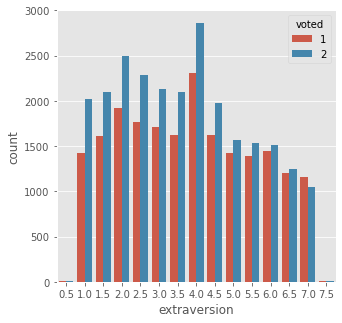

In [62]:
sns.countplot(data=train, x='extraversion', hue='voted')

<AxesSubplot:xlabel='extraversion', ylabel='count'>

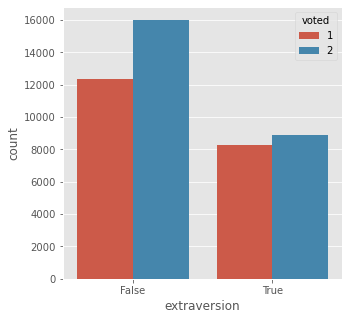

In [63]:
train['extraversion']=(train['extraversion']>4.44)
test['extraversion']=(test['extraversion']>4.44)
sns.countplot(data=train, x='extraversion', hue='voted')

별로 연관있는 항목은 아니었다

In [64]:
#train.drop(columns='extraversion',inplace=True)
#test.drop(columns='extraversion',inplace=True)

#### 5.2.2 agreeableness

<AxesSubplot:xlabel='agreeableness', ylabel='count'>

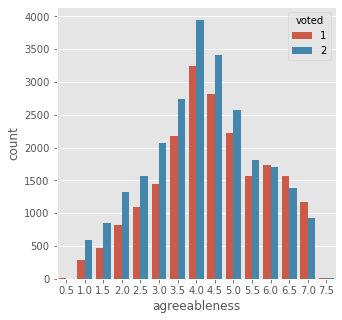

In [65]:
sns.countplot(data=train, x='agreeableness', hue='voted')

<AxesSubplot:xlabel='agreeableness', ylabel='count'>

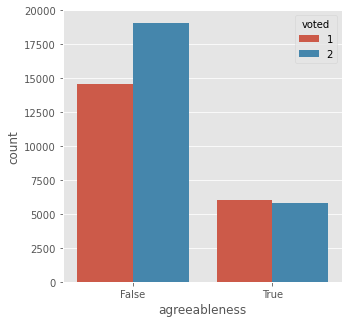

In [66]:
train['agreeableness']=(train['agreeableness']>5.23)
test['agreeableness']=(test['agreeableness']>5.23)
sns.countplot(data=train, x='agreeableness', hue='voted')

#### 5.2.3 conscientiousness

<AxesSubplot:xlabel='conscientiousness', ylabel='count'>

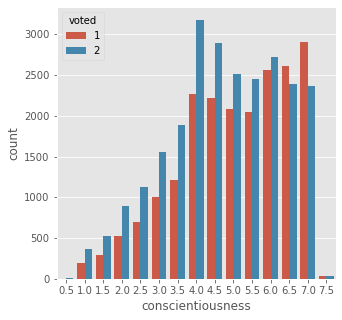

In [67]:
sns.countplot(data=train, x='conscientiousness', hue='voted')

<AxesSubplot:xlabel='conscientiousness', ylabel='count'>

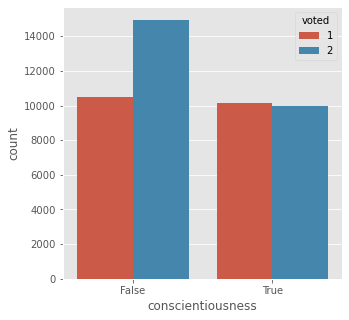

In [68]:
train['conscientiousness']=(train['conscientiousness']>5.4)
test['conscientiousness']=(test['conscientiousness']>5.4)
sns.countplot(data=train, x='conscientiousness', hue='voted')

#### 5.2.4 emotion_stability

<AxesSubplot:xlabel='emotion_stability', ylabel='count'>

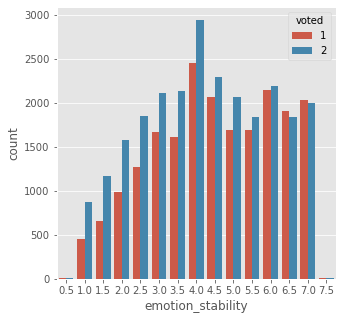

In [69]:
sns.countplot(data=train, x='emotion_stability', hue='voted')

<AxesSubplot:xlabel='emotion_stability', ylabel='count'>

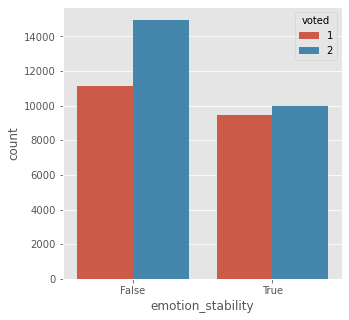

In [70]:
train['emotion_stability']=(train['emotion_stability']>4.83)
test['emotion_stability']=(test['emotion_stability']>4.83)
sns.countplot(data=train, x='emotion_stability', hue='voted')

In [71]:
#train.drop(columns='emotion_stability',inplace=True)
#test.drop(columns='emotion_stability',inplace=True)

#### 5.2.5 open-mind

<AxesSubplot:xlabel='openness_toexp', ylabel='count'>

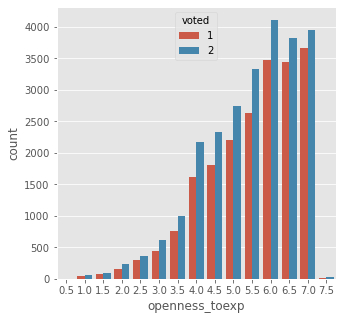

In [72]:
sns.countplot(data=train, x='openness_toexp', hue='voted')

<AxesSubplot:xlabel='openness_toexp', ylabel='count'>

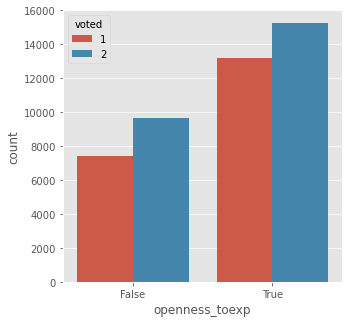

In [73]:
train['openness_toexp']=(train['openness_toexp']>5.38)
test['openness_toexp']=(test['openness_toexp']>5.38)
sns.countplot(data=train, x='openness_toexp', hue='voted')

In [74]:
#train.drop(columns='openness_toexp',inplace=True)
#test.drop(columns='openness_toexp',inplace=True)

### 5.3) Q_A/Q_E
https://openpsychometrics.org/tests/MACH-IV/demographic-correlations-and-statistics/
이부분은 마키아벨리즘 테스트에서 착안해온것인데 , 흔히 말하는 사이코패스 테스트 같은 것 ! -> 5가지 특성 요소 중 친화성 낮고 성실성 높게 나오는 경향 가짐
극단적인 경우에, '낮은 성향'의 사람들은 수동적이며,순종적이고,타인의 의견에 순응하며 의존적이고 사회적으로 서투를 수 있다. '높은 성향'의 사람들과는 반대로, 그들은 모든 인간에게는 좋은 면과 나쁜 면이 있다고 믿는다.[6]

Scores can range from 20 (the least Machiavellian) to 100 (the most Machiavellian). Those scoring 60 or more are considered as ‘high Machs,’ while those scoring below 60 are considered as ‘low Machs.’

근데 이테스트에서 100점 만점이 이므로 있는 질문들 중에 역으로 구상해야할 질문 고르고 나머지로 경향성 찾아보자

Qa : Secret

Qb : The biggest difference between most criminals and other people is that the criminals are stupid enough to get caught. (1)

Qc : Anyone who completely trusts anyone else is asking for trouble. (1)

Qd : Secret

Qe : P.T. Barnum was wrong when he said that there's a sucker born every minute.(0)

Qf : There is no excuse for lying to someone else.(0)

Qg : Secret

Qh : Most people forget more easily the death of their parents than the loss of their property. (1)

Qi : Secret

Qj : It is safest to assume that all people have a vicious streak and it will come out when they are given a chance.(1)

Qk : All in all, it is better to be humble and honest than to be important and dishonest.(0)

Ql : Secret

Qm : It is hard to get ahead without cutting corners here and there.(1)

Qn : Secret 

Qo : The best way to handle people is to tell them what they want to hear. (1)

Qp : Secret

Qq : Most people are basically good and kind.(0) 

Qr : One should take action only when sure it is morally right. (0)

Qs : It is wise to flatter important people.(1)

Qt : Secret



In [75]:
train['PM']=train['QbA']+train['QcA']+train['QhA']+train['QjA']+train['QmA']+train['QoA']+train['QsA']
train['NM']=train['QeA']+train['QfA']+train['QkA']+train['QqA']+train['QrA']

#### Qa

<AxesSubplot:xlabel='PM', ylabel='count'>

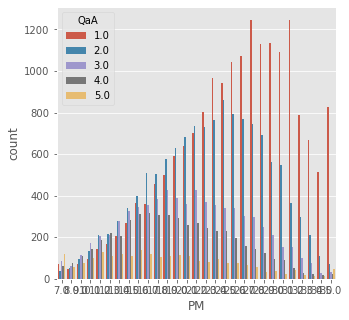

In [76]:
sns.countplot(data=train, x='PM', hue='QaA')

<AxesSubplot:xlabel='NM', ylabel='count'>

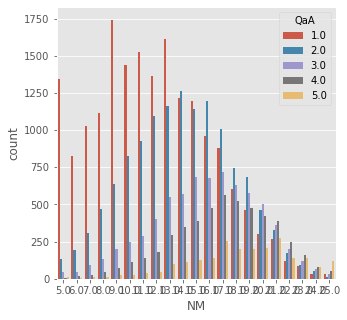

In [77]:
sns.countplot(data=train, x='NM', hue='QaA')

즉, Qa의 질문이 뭔지는 몰라도 Qa는 PM이 높을수록 1점이 많아->  NM에 속해야함

#### Qd

<AxesSubplot:xlabel='PM', ylabel='count'>

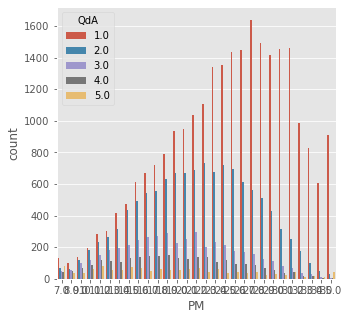

In [78]:
sns.countplot(data=train, x='PM', hue='QdA')

<AxesSubplot:xlabel='NM', ylabel='count'>

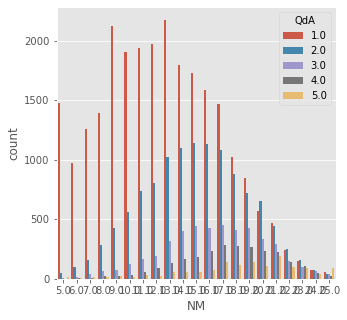

In [79]:
sns.countplot(data=train, x='NM', hue='QdA')

그러니까 얘는 PM클수록 1점 많이준거라 ->NM에 속해야지

#### Qg

<AxesSubplot:xlabel='PM', ylabel='count'>

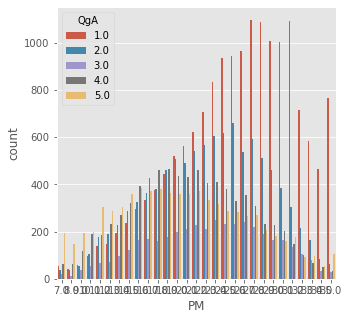

In [80]:
sns.countplot(data=train, x='PM', hue='QgA')

<AxesSubplot:xlabel='NM', ylabel='count'>

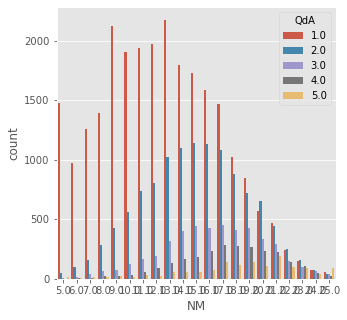

In [81]:
sns.countplot(data=train, x='NM', hue='QdA')

-> 얘도 NM

#### Qi

<AxesSubplot:xlabel='PM', ylabel='count'>

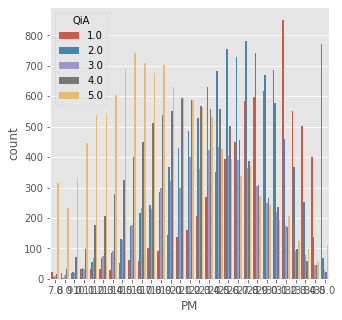

In [82]:
sns.countplot(data=train, x='PM', hue='QiA')

<AxesSubplot:xlabel='NM', ylabel='count'>

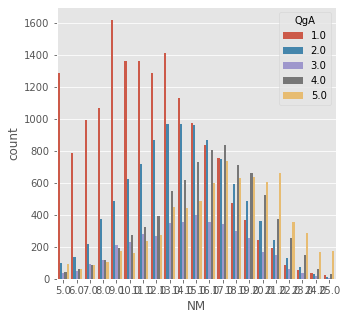

In [83]:
sns.countplot(data=train, x='NM', hue='QgA')

얘도 NM 

#### Ql

<AxesSubplot:xlabel='PM', ylabel='count'>

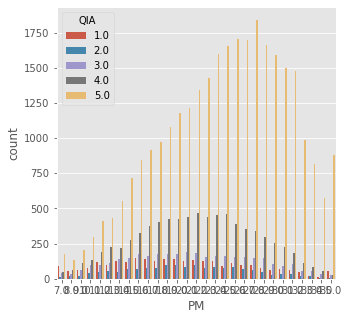

In [84]:
sns.countplot(data=train, x='PM', hue='QlA')

<AxesSubplot:xlabel='NM', ylabel='count'>

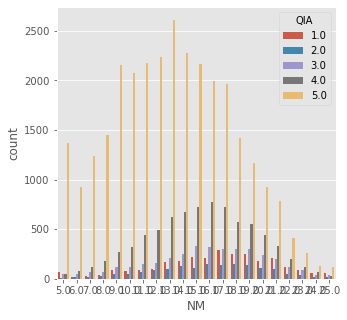

In [85]:
sns.countplot(data=train, x='NM', hue='QlA')

얘는 PM

#### Qn

<AxesSubplot:xlabel='PM', ylabel='count'>

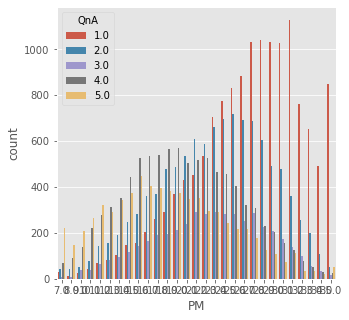

In [86]:
sns.countplot(data=train, x='PM', hue='QnA')

<AxesSubplot:xlabel='NM', ylabel='count'>

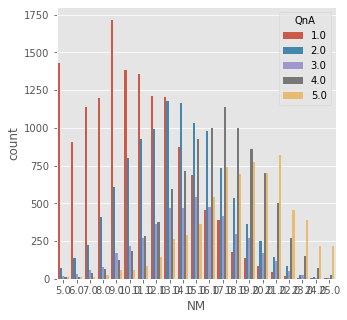

In [87]:
sns.countplot(data=train, x='NM', hue='QnA')

NM

#### Qp

<AxesSubplot:xlabel='PM', ylabel='count'>

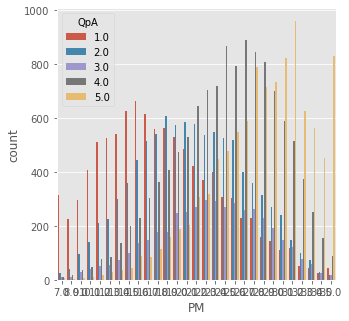

In [88]:
sns.countplot(data=train, x='PM', hue='QpA')

<AxesSubplot:xlabel='NM', ylabel='count'>

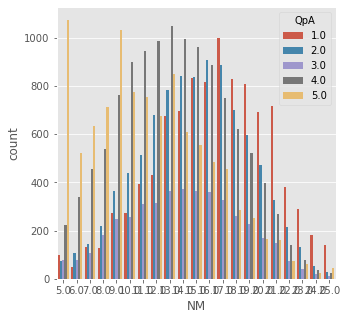

In [89]:
sns.countplot(data=train, x='NM', hue='QpA')

PM

#### Qt

<AxesSubplot:xlabel='PM', ylabel='count'>

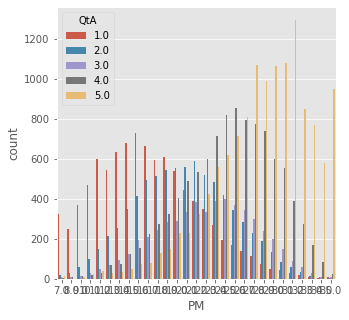

In [90]:
sns.countplot(data=train, x='PM', hue='QtA')

<AxesSubplot:xlabel='NM', ylabel='count'>

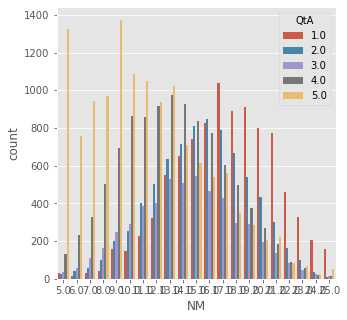

In [91]:
sns.countplot(data=train, x='NM', hue='QtA')

PM

### 
Qa : Secret(0)

Qb : The biggest difference between most criminals and other people is that the criminals are stupid enough to get caught. (1)

Qc : Anyone who completely trusts anyone else is asking for trouble. (1)

Qd : Secret(0)

Qe : P.T. Barnum was wrong when he said that there's a sucker born every minute.(0)

Qf : There is no excuse for lying to someone else.(0)

Qg : Secret(0)

Qh : Most people forget more easily the death of their parents than the loss of their property. (1)

Qi : Secret(0)

Qj : It is safest to assume that all people have a vicious streak and it will come out when they are given a chance.(1)

Qk : All in all, it is better to be humble and honest than to be important and dishonest.(0)

Ql : Secret(1)

Qm : It is hard to get ahead without cutting corners here and there.(1)

Qn : Secret (0)

Qo : The best way to handle people is to tell them what they want to hear. (1)

Qp : Secret(1)

Qq : Most people are basically good and kind.(0) 

Qr : One should take action only when sure it is morally right. (0)

Qs : It is wise to flatter important people.(1)

Qt : Secret(1)

그렇게 되면 지문의 1:1 개수와도 아주 정확히 맞는다.


In [92]:
train['MK']=train['QbA']+train['QcA']+train['QhA']+train['QjA']+train['QlA']+train['QmA']+train['QoA']+train['QpA']+train['QsA']+train['QtA']+(6-train['QaA'])+(6-train['QdA'])+(6-train['QeA'])+(6-train['QfA'])+(6-train['QgA'])+(6-train['QiA'])+(6-train['QkA'])+(6-train['QnA'])+(6-train['QqA'])+(6-train['QrA'])
test['MK']=test['QbA']+test['QcA']+test['QhA']+test['QjA']+test['QlA']+test['QmA']+test['QoA']+test['QpA']+test['QsA']+test['QtA']+(6-test['QaA'])+(6-test['QdA'])+(6-test['QeA'])+(6-test['QfA'])+(6-test['QgA'])+(6-test['QiA'])+(6-test['QkA'])+(6-test['QnA'])+(6-test['QqA'])+(6-test['QrA'])
train['MK']=train['MK']/100
test['MK']=test['MK']/100
train

,QaA,QaE,QbA,QbE,QcA,QcE,QdA,QdE,QeA,QeE,...,white,wise,extraversion,agreeableness,conscientiousness,emotion_stability,openness_toexp,PM,NM,MK
index,,,,,,,,,,,,,,,,,,,,,
0,3.0,363,4.0,1370,5.0,997,1.0,1024,2.0,1577,...,True,False,False,False,False,False,False,23.0,15.0,0.59
1,5.0,647,5.0,1313,3.0,3387,5.0,2969,1.0,4320,...,False,False,True,False,True,False,True,18.0,15.0,0.52
2,4.0,1623,1.0,1480,1.0,1021,4.0,3374,5.0,1333,...,True,False,True,False,True,True,False,10.0,20.0,0.38
3,3.0,504,3.0,2311,4.0,992,3.0,3245,1.0,357,...,False,False,True,True,False,False,False,26.0,13.0,0.67
4,1.0,927,1.0,707,5.0,556,2.0,1062,1.0,1014,...,True,True,True,False,True,True,True,18.0,18.0,0.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45527,2.0,1050,5.0,619,4.0,328,1.0,285,1.0,602,...,True,False,True,False,False,False,False,25.0,9.0,0.83
45528,2.0,581,3.0,1353,4.0,1164,1.0,798,3.0,1680,...,True,True,True,False,False,True,True,24.0,12.0,0.76
45529,4.0,593,1.0,857,1.0,1047,4.0,1515,5.0,1690,...,True,False,False,True,False,True,True,9.0,24.0,0.30


<AxesSubplot:xlabel='MK', ylabel='count'>

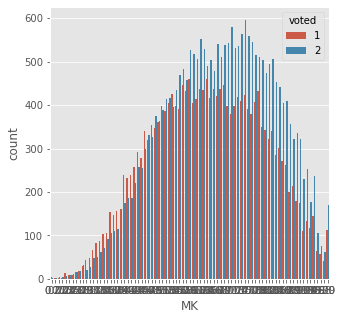

In [93]:
sns.countplot(data=train, x='MK', hue='voted')

<AxesSubplot:xlabel='MK', ylabel='count'>

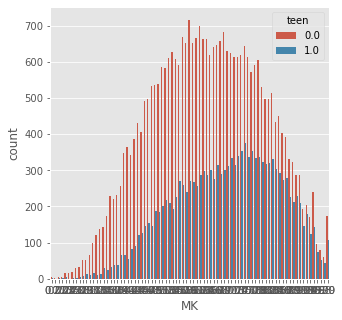

In [94]:
sns.countplot(data=train, x='MK', hue='teen')

In [95]:
train.drop(columns=['QaA','QaE','QbA','QbE','QcA','QcE','QdA','QdE','QeA','QeE','QfA','QfE','QgA','QgE','QhA','QhE','QiA','QiE','QjA','QjE','QkA','QkE','QlA','QlE','QmA','QmE','QnA','QnE','QoA','QoE','QpA','QpE','QqA','QqE','QrA','QrE','QsA','QsE','QtA','QtE'],inplace=True)
test.drop(columns=['QaA','QaE','QbA','QbE','QcA','QcE','QdA','QdE','QeA','QeE','QfA','QfE','QgA','QgE','QhA','QhE','QiA','QiE','QjA','QjE','QkA','QkE','QlA','QlE','QmA','QmE','QnA','QnE','QoA','QoE','QpA','QpE','QqA','QqE','QrA','QrE','QsA','QsE','QtA','QtE'],inplace=True)
train.drop(columns=['PM','NM'],inplace=True)

### 마지막 특성 추출

<AxesSubplot:xlabel='MK', ylabel='count'>

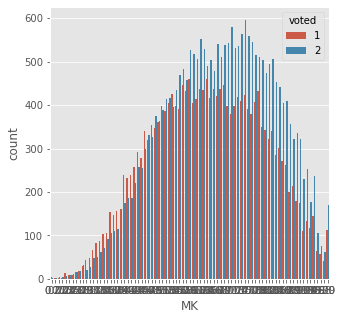

In [96]:
sns.countplot(data=train, x='MK', hue='voted')

<AxesSubplot:xlabel='MK', ylabel='count'>

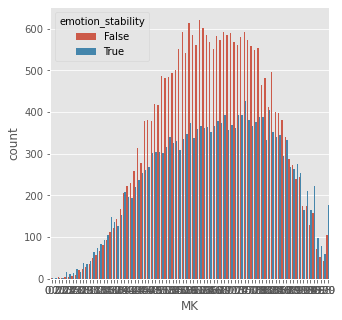

In [97]:
sns.countplot(data=train, x='MK', hue='emotion_stability')

<AxesSubplot:xlabel='MK', ylabel='count'>

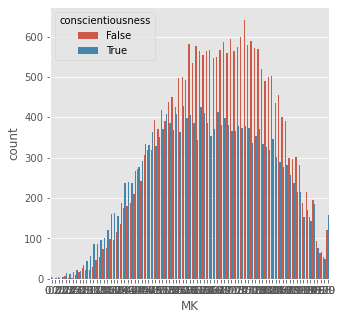

In [98]:
sns.countplot(data=train, x='MK', hue='conscientiousness')

<AxesSubplot:xlabel='MK', ylabel='count'>

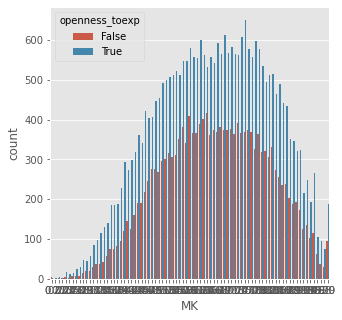

In [99]:
sns.countplot(data=train, x='MK', hue='openness_toexp')

<AxesSubplot:xlabel='MK', ylabel='count'>

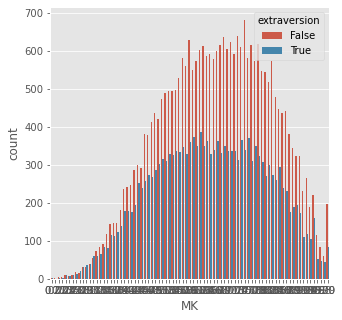

In [100]:
sns.countplot(data=train, x='MK', hue='extraversion')

<AxesSubplot:xlabel='MK', ylabel='count'>

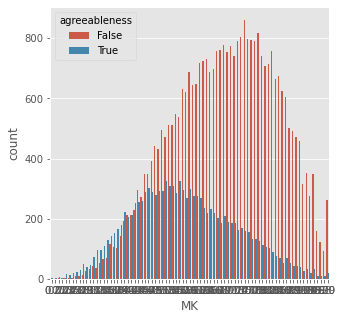

In [101]:
sns.countplot(data=train, x='MK', hue='agreeableness')

In [102]:
train

,education,voted,teen,married,white,wise,extraversion,agreeableness,conscientiousness,emotion_stability,openness_toexp,MK
index,,,,,,,,,,,,
0,0,2,0.0,1,True,False,False,False,False,False,False,0.59
1,1,2,0.0,0,False,False,True,False,True,False,True,0.52
2,1,1,0.0,1,True,False,True,False,True,True,False,0.38
3,1,1,0.0,0,False,False,True,True,False,False,False,0.67
4,1,1,0.0,1,True,True,True,False,True,True,True,0.60
...,...,...,...,...,...,...,...,...,...,...,...,...
45527,0,2,1.0,0,True,False,True,False,False,False,False,0.83
45528,0,2,0.0,0,True,True,True,False,False,True,True,0.76
45529,0,1,1.0,0,True,False,False,True,False,True,True,0.30


## 6. 검증 
시간 부분은 빼고 나머지 데이터만 모아 얼추 검증해본다.  
정확도가 너무 낮으면 overfitting / underfitting 일어났을 확률 높다.
1. overfitting = 학습 데이터가 너무 많아 학습 데이터에만 지나치게 의존하여 학습
2. underfitting = 학습 데이터가 모자라서 학습이 불충분하게 진행

이를 피하기 위해서 학습 데이터에서 검증 데이터를 빼서 검증 데이터로 검증하는 과정을 거쳐야 한다. 
검증 데이터를 작성하는 방법으로는 , 
1. 홀드 아웃 = 데이터를 일정한 비율(8:2)로 학습 데이터와 검증 데이터로 분할하는 방법
2. 교차 검증 = 데이터 전체를 임의의 수의 블록으로 분할해서 그 중 블록 한개는 검증 데이터로 만들고 나머지는 학습 데이터로 만드는 방법 
3. 잭나이프 법 = 전체 중 하나를 검증 데이터로 , 나머지를 학습 데이터로 하는 과정을 전체 데이터 수만큼 반복하는 방법

### 6.0 데이터 target 나누기

#### train_test_split
train_test_split()의 파라미터는

+ iris_data : feature data set

+ iris_label : label data set

+ test_size=0.2 : 전체 데이터 세트 중 테스트 데이터 세트의 비율

+ random_state=11 : 호출할 때마다 같은 학습/테스트 용 데이터 세트를 생성하기 위해 주어지는 난수 발생 값  train_test_split()는 호출 시 무작위로 데이터를 분리하므로 random_state를 지정하지 않으면 수행할 때마다 다른 학습/테스트 용 데이터를 만들 수 있음. 동일한 데이터 세트로 분리하기 위해 random_state를 일정한 숫자 값으로 부여하면 됨.

In [103]:
train_feature = train[~train["voted"].isnull()].drop("voted",axis=1).reset_index(drop=True)
train_target = train["voted"]
train_feature_only = train[train["voted"].isnull()].drop("voted",axis=1).reset_index(drop=True)
train_target = np.where(train_target == 2, 0, train_target)
train_target

array([0, 0, 1, ..., 1, 1, 1], dtype=int64)

In [104]:
feature_train, feature_valid,target_train, target_valid = train_test_split(train_feature, train_target, test_size=0.1)
feature_train

,education,teen,married,white,wise,extraversion,agreeableness,conscientiousness,emotion_stability,openness_toexp,MK
1528,0,1.0,0,False,False,True,False,True,False,True,0.64
37300,0,1.0,0,False,False,False,False,True,True,True,0.80
12008,0,1.0,0,True,False,False,True,True,True,False,0.47
36991,0,0.0,1,False,False,True,False,True,True,False,0.50
39773,0,1.0,0,False,False,True,False,True,False,True,0.68
...,...,...,...,...,...,...,...,...,...,...,...
14772,1,0.0,1,True,True,True,False,True,True,False,0.56
41325,1,0.0,1,True,False,False,False,True,False,False,0.56
18485,1,0.0,1,True,True,False,True,True,False,True,0.44
36687,0,0.0,0,True,False,False,False,True,True,False,0.58


#### 교차검증(cross_val_score)
그냥 연습하려고 써두긴 했는데 모델이 있어야하니까 그냥 주석처리한다 

+ estimator : 사이킷런의 분류 알고리즘 클래스인 Classfier 또는 회귀 알고리즘 클래스인 Regressor를 의미

+ x : 피처 데이터 세트

+ y : 레이블 데이터 세트

+ scoring : 예측 성능 평가 지표 기술, 원하는 지표를 정확하게 넣어주어야 함. 

+ cv : 교차 검증 폴드 수를 의미

In [105]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
model=LinearRegression()
#scores=cross_val_score(model,train,test,scoring='neg_mean_square_error',cv=10)
#rmse=np.sqrt(-scores)
#printf(rmse.mean())

### 6.1 XG boost
kaggle에서 가장 우승한 전력이 많은 알고리즘이래 ...... 그런데 under/overfitting 일어날 확률이 높다고 함 -> 검증 과정 반드시 거치기
https://wooono.tistory.com/97

https://www.youtube.com/watch?v=VHky3d_qZ_E

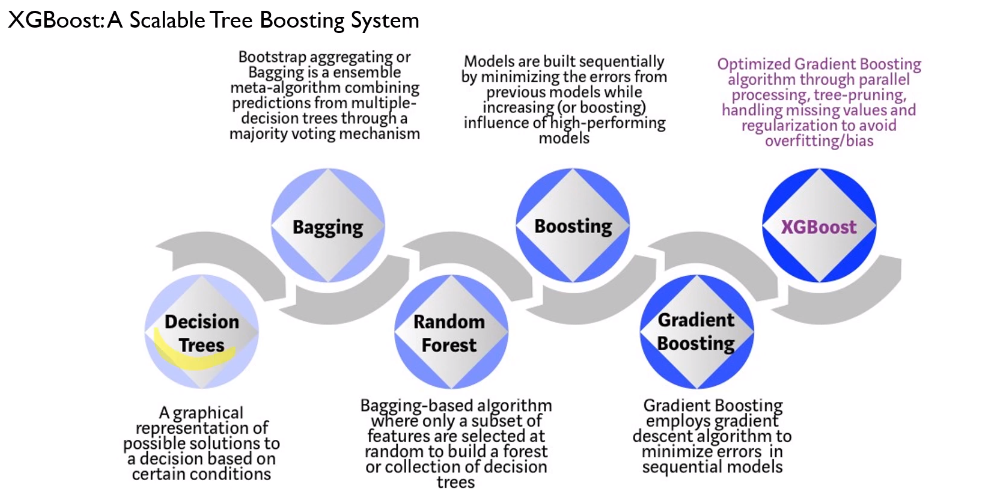

In [106]:
from IPython.display import Image 
Image("C:/Users/jihyu/OneDrive/바탕 화면/XG_boost.png",width=700)

In [107]:
import xgboost as xgb
import matplotlib.pyplot as plt
model = xgb.XGBClassifier(learning_rate=0.02,min_child_weight=1,max_depth=6,gamma=0.1,colsample_bytree=1,subsample=0.2,n_estimators=140)
model.fit(feature_train,target_train) 
prediction = model.predict(feature_valid)
print(accuracy_score(target_valid, np.round(prediction)))
scores=cross_val_score(model,train_feature,train_target,scoring='accuracy',cv=10)
print(scores.mean())

0.6798418972332015
0.6863964466328889


In [108]:
import xgboost as xgb
import matplotlib.pyplot as plt

model = xgb.XGBClassifier(learning_rate=0.02,min_child_weight=1,max_depth=6,gamma=0.1,colsample_bytree=1,subsample=0.2,n_estimators=140)
model.fit(train_feature,train_target) 
prediction = model.predict(test)
prediction = np.where(prediction == 0, 2, prediction)
submission['voted']=prediction
submission.to_csv("C:/Users/jihyu/OneDrive/바탕 화면/submission.csv")
prediction

array([2, 2, 2, ..., 1, 1, 2])

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

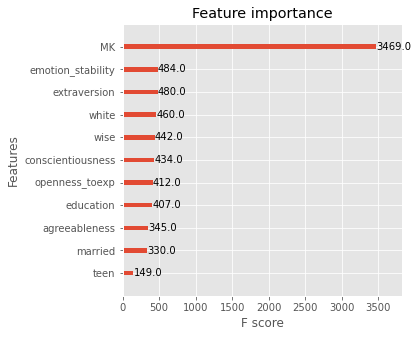

In [109]:
import xgboost as xgb

xgb.plot_importance(model)

#### 6.2 lightgbm

In [110]:
import optuna
from sklearn.model_selection import train_test_split
import lightgbm as lgb

In [111]:
import lightgbm as lgbm
import matplotlib.pyplot as plt

model = lgbm.LGBMClassifier(learning_rate=0.03,num_leaves=13,min_child_samples=25,max_depth=6,min_child_weight=4)
model.fit(feature_train,target_train) 
prediction = model.predict(feature_valid)
print(accuracy_score(target_valid, np.round(prediction)))
scores=cross_val_score(model,train_feature,train_target,scoring='accuracy',cv=10)
print(scores.mean())

0.6785243741765481
0.6853423317293293


In [112]:
import matplotlib.pyplot as plt

model = lgbm.LGBMClassifier(learning_rate=0.03,num_leaves=13,min_child_samples=25,max_depth=6,min_child_weight=4)
model.fit(train_feature,train_target) 
prediction = model.predict(test)
prediction = np.where(prediction == 0, 2, prediction)
submission['voted']=prediction
submission.to_csv("C:/Users/jihyu/OneDrive/바탕 화면/submission.csv")
prediction

array([2, 2, 2, ..., 1, 1, 2], dtype=int64)